In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:4'

FREERUN = 20
DT = .02

rho = 28.0
sigma = 10.0
beta = 8/3

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]
t = np.arange(0,300+FREERUN,DT)
states = odeint(f,state0,t)

muX = np.mean(states[:,0])
signal = states[:,0]-muX

M = signal.shape[0] - int(FREERUN/DT)
K = 1
L = 1
RF = .5
TEST = 1000
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST


MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
BINS = 50

print(f'Signal length M={M}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0
Signal length M=15000


In [2]:
np.save('./Targets/Xsignal',signal)

In [3]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [4]:
min_a, max_a = .25, .4
min_sr, max_sr = 1.25, 1.45
min_g, max_g = .8, 1.1
min_ri, max_ri = .001, 4.
min_rr, max_rr = .001, 4.
space = [Real(min_a, max_a, name='a'),
                 Real(min_sr, max_sr, name='sr'),
                 Real(min_g, max_g, name='amp'), 
                 Real(min_ri, max_ri, name='ri'),
                 Real(min_rr, max_rr, name='rr')
                ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,amp=1.0,ri=1.0,rr=1.0):
    start = time.time()
    global running_error, s, counter, signal, N, \
           alphas, rhos, gammas, inScales, resScales
    
    ut = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    tp = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                          device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype,
                          device=DEVICE)
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 

    state = states.detach().cpu().numpy()

    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE)
    torch.cuda.synchronize()

    predictions = torch.zeros((M+int(FREERUN/DT),1),
                              dtype=dtype,
                              device=torch.device(DEVICE))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+int(FREERUN/DT)):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST],
                          yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST],
                          MINMAX) 
    except:
        pass
    
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse + dist
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000
    
    if((loss < running_error) & (loss < .85)):
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.set_ylim(-25,25)
        ax1.legend()
        plt.show()
        fig.savefig(f'./X_Saved_Models/X_sz{N}_ref{ref}_run{rn}_iter{counter}.pdf',
                    format='pdf', bbox_inches='tight', pad_inches=.01)
        plt.close()
        
        np.save(f'./X_Saved_Models/X_it{counter}_{N}_{ref}_{rn}_Wnet',wnet)
        np.save(f'./X_Saved_Models/X_it{counter}_{N}_{ref}_{rn}_Preds',yHat_GPU)
        np.save(f'./X_Saved_Models/X_it{counter}_{N}_{ref}_{rn}_InstanceParams',currentParams)
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    ####### Running info ##############################
    print(f'Iter: {counter} #### Diagnostic {loss:3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {nrmse:.3f} CD {dist:.3f}')
    ###### Store this run #############################
    counter += 1
    return loss

********** Size 300 -- Run 0 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 10.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 5.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 5.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 5.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 5.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 6.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 5.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 6.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 5.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 4.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 5.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnost

Iter: 96 #### Diagnostic 1000.000000   Time 6.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 8.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 9.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 7.14  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 1.4101497374720258
a = 0.25187500921617856
sr = 1.2563172831968683
amp = 0.8944346142883591
ri = 0.05421742660855553
rr = 0.8675490752890223
********** Size 300 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 6.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 7.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 6.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 7.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 8.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.00000

Iter: 90 #### Diagnostic 1000.000000   Time 7.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 6.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 7.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 8.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 7.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 7.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 5.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 7.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 8.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1.381574   Time 7.42  Best 1000.000 NRMSE 0.346 CD 1.035

Best result = 1.3149033343975929
a = 0.26223089238436553
sr = 1.310994018042007
amp = 0.8000996166918959
ri = 3.8273375255423954
rr = 3.2247259

Iter: 84 #### Diagnostic 1000.000000   Time 11.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 7.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 5.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 6.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 5.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 7.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 6.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 6.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 6.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 6.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 8.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 7.16  Bes

Iter: 78 #### Diagnostic 1000.000000   Time 6.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 8.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 6.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 6.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 7.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 8.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 8.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 9.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 5.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 6.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 7.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 7.95  Best

Iter: 72 #### Diagnostic 1000.000000   Time 9.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 6.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 6.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1.378168   Time 7.33  Best 1000.000 NRMSE 0.313 CD 1.065
Iter: 76 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 10.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 10.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 8.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 7.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 8.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 7.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1.098627   Time 7.93  Best 1000

Iter: 63 #### Diagnostic 1000.000000   Time 6.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 8.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 9.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 7.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 7.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 6.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 6.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 8.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 8.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 9.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 8.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 8.88  Best

Iter: 57 #### Diagnostic 1000.000000   Time 7.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 9.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 8.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 8.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 8.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 5.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 7.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 8.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 8.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1.031793   Time 7.95  Best 1000.000 NRMSE 0.257 CD 0.774
Iter: 67 #### Diagnostic 1000.000000   Time 9.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 5.53  Best 100

Iter: 51 #### Diagnostic 1000.000000   Time 10.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 8.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 6.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 6.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 8.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 8.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 0.929686   Time 5.31  Best 1000.000 NRMSE 0.250 CD 0.680
Iter: 58 #### Diagnostic 1000.000000   Time 7.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 8.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 8.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 7.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1.018053   Time 7.65  Best 1000.

Iter: 45 #### Diagnostic 1000.000000   Time 7.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 7.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 7.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 9.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 7.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 10.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 7.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 6.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 6.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 7.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 7.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 6.46  Bes

Iter: 39 #### Diagnostic 1000.000000   Time 7.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 8.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 8.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 8.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 6.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 8.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 8.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 7.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 6.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 8.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.078257   Time 6.50  Best 1000.000 NRMSE 0.263 CD 0.815
Iter: 50 #### Diagnostic 1000.000000   Time 8.74  Best 100

Iter: 31 #### Diagnostic 1000.000000   Time 7.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 9.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 7.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 7.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 6.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 6.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 5.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 6.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 6.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 7.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 9.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 8.73  Best

Iter: 25 #### Diagnostic 1000.000000   Time 7.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 6.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 8.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 9.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 6.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 7.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 7.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 8.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 9.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 6.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 6.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 6.54  Best

Iter: 19 #### Diagnostic 1000.000000   Time 7.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 7.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 7.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 7.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 7.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 6.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 6.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 8.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 7.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 9.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 6.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 6.20  Best

Iter: 13 #### Diagnostic 1000.000000   Time 6.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 6.48  Best 1000.000 NRMSE 22182452.885 CD 1.017
Iter: 15 #### Diagnostic 1000.000000   Time 7.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 7.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 6.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 8.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 7.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 5.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 6.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 8.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 8.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 7.66

Iter: 7 #### Diagnostic 1000.000000   Time 7.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 5.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 6.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 8.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 9.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 8.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 8.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 7.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 7.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 8.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 7.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 6.51  Best 10

Iter: 0 #### Diagnostic 1000.000000   Time 7.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 10.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 7.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 9.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 6.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 7.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1.192220   Time 7.92  Best 1000.000 NRMSE 0.281 CD 0.911
Iter: 7 #### Diagnostic 1000.000000   Time 6.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 7.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 6.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 6.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 10.00  Best 1000.000 NR

Iter: 96 #### Diagnostic 1000.000000   Time 6.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 6.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 7.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 8.36  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 1.1922200581181075
a = 0.3431923238724236
sr = 1.3384944986072915
amp = 1.0692989228711967
ri = 0.27730213446902385
rr = 2.026195125724826
********** Size 300 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 7.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 6.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 5.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 7.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 8.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000 

Iter: 90 #### Diagnostic 1000.000000   Time 8.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 6.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 6.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 7.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 6.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 6.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 7.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 9.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 9.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1.123743   Time 7.56  Best 1000.000 NRMSE 0.274 CD 0.849

Best result = 1.1237429880331231
a = 0.31854803733198916
sr = 1.4429530044400285
amp = 0.9196732042347396
ri = 0.08727958630659896
rr = 3.56594

Iter: 84 #### Diagnostic 1000.000000   Time 7.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 6.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 7.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 5.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 9.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 8.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 9.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 8.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 8.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1.238065   Time 6.53  Best 1000.000 NRMSE 0.291 CD 0.947
Iter: 94 #### Diagnostic 1000.000000   Time 8.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 6.01  Best 100

Iter: 78 #### Diagnostic 1000.000000   Time 6.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 6.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 10.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 9.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 8.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 7.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 7.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 6.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 7.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 5.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 5.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 7.76  Bes

Iter: 72 #### Diagnostic 1000.000000   Time 8.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 7.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1.127417   Time 6.79  Best 1000.000 NRMSE 0.285 CD 0.843
Iter: 76 #### Diagnostic 1000.000000   Time 9.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 8.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 8.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 7.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 9.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 5.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 6.44  Best 1000.000 NRMSE 1000.000 CD nan


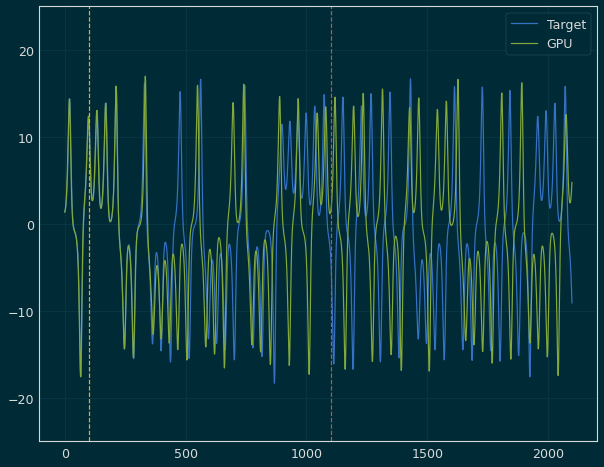

 Iter=83 a=0.384 sr=1.450 amp=1.044  ri=0.140 rr=2.822 loss=0.620635


Iter: 83 #### Diagnostic 0.620635   Time 6.07  Best 0.621 NRMSE 0.193 CD 0.428
Iter: 84 #### Diagnostic 1000.000000   Time 6.36  Best 0.621 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 7.48  Best 0.621 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 6.47  Best 0.621 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 6.67  Best 0.621 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 7.45  Best 0.621 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 5.91  Best 0.621 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 7.46  Best 0.621 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 6.66  Best 0.621 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 8.09  Best 0.621 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 7.92  Best 0.621 NRMSE 1000.000 CD nan
Iter: 94 #### Diagno

Iter: 70 #### Diagnostic 1000.000000   Time 5.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 7.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 6.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 6.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 6.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 6.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 7.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 6.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 6.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 8.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 6.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 6.54  Best

Iter: 64 #### Diagnostic 1000.000000   Time 7.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 7.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1.078175   Time 7.57  Best 1000.000 NRMSE 0.262 CD 0.816
Iter: 67 #### Diagnostic 1000.000000   Time 6.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 5.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 8.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 8.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 6.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 6.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 9.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 6.63  Best 100

Iter: 58 #### Diagnostic 1000.000000   Time 5.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 6.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 6.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 8.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1.097689   Time 5.98  Best 1000.000 NRMSE 0.270 CD 0.827
Iter: 63 #### Diagnostic 1000.000000   Time 8.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 8.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 8.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 7.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 6.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 6.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 7.47  Best 100

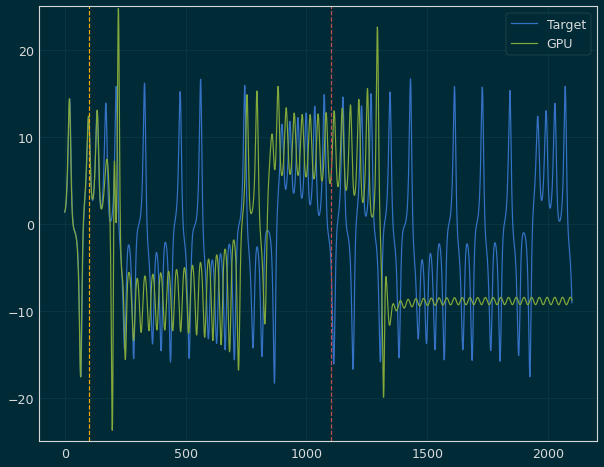

 Iter=79 a=0.390 sr=1.403 amp=0.941  ri=0.177 rr=2.050 loss=0.801863


Iter: 79 #### Diagnostic 0.801863   Time 8.94  Best 0.802 NRMSE 0.235 CD 0.567
Iter: 80 #### Diagnostic 1000.000000   Time 8.85  Best 0.802 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 7.20  Best 0.802 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 9.23  Best 0.802 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 6.78  Best 0.802 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 9.67  Best 0.802 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 6.49  Best 0.802 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 5.45  Best 0.802 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 6.47  Best 0.802 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 6.19  Best 0.802 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 6.63  Best 0.802 NRMSE 1000.000 CD nan
Iter: 90 #### Diagno

Iter: 73 #### Diagnostic 0.915990   Time 8.32  Best 1000.000 NRMSE 0.242 CD 0.674
Iter: 74 #### Diagnostic 1000.000000   Time 8.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 9.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 8.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 6.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1.353225   Time 6.02  Best 1000.000 NRMSE 0.301 CD 1.052
Iter: 79 #### Diagnostic 1000.000000   Time 6.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 7.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 6.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 6.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 5.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 6.57  Best 1000.00

Iter: 67 #### Diagnostic 1000.000000   Time 7.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 6.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 6.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 6.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 5.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 5.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 7.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 6.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1.257120   Time 5.00  Best 1000.000 NRMSE 0.300 CD 0.957
Iter: 76 #### Diagnostic 1000.000000   Time 6.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 5.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 7.24  Best 100

Iter: 54 #### Diagnostic 1000.000000   Time 5.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 5.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 5.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 4.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 5.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 6.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 7.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 5.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 5.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 6.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 5.08  Best

Iter: 48 #### Diagnostic 1000.000000   Time 5.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 5.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 5.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 5.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 6.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 4.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 5.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 4.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 5.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 6.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 7.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 5.54  Best

Iter: 42 #### Diagnostic 1000.000000   Time 5.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 4.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1.390330   Time 6.69  Best 1000.000 NRMSE 0.308 CD 1.082
Iter: 45 #### Diagnostic 1.380444   Time 5.37  Best 1000.000 NRMSE 0.329 CD 1.051
Iter: 46 #### Diagnostic 1000.000000   Time 5.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 5.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 5.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 5.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.327589   Time 6.86  Best 1000.000 NRMSE 0.292 CD 1.035
Iter: 51 #### Diagnostic 1000.000000   Time 4.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 5.51  Best 1000.000 NR

Iter: 36 #### Diagnostic 1000.000000   Time 5.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 4.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 5.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 5.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 6.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 5.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 4.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 5.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 4.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 6.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 6.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 6.11  Best

Iter: 30 #### Diagnostic 1000.000000   Time 5.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 5.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 5.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 5.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 6.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 4.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 5.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.349975   Time 5.75  Best 1000.000 NRMSE 0.309 CD 1.041
Iter: 38 #### Diagnostic 1000.000000   Time 5.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 4.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 4.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 5.86  Best 100

Iter: 22 #### Diagnostic 1.350833   Time 6.45  Best 1000.000 NRMSE 0.308 CD 1.042
Iter: 23 #### Diagnostic 1000.000000   Time 5.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 5.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 4.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 4.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 4.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 6.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.324874   Time 5.62  Best 1000.000 NRMSE 0.296 CD 1.029
Iter: 30 #### Diagnostic 1000.000000   Time 6.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 5.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 5.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 4.85  Best 1000.00

Iter: 16 #### Diagnostic 1000.000000   Time 6.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 5.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 4.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 6.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 4.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 4.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 4.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 5.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 5.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 5.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 5.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 4.66  Best

Iter: 10 #### Diagnostic 1000.000000   Time 7.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 4.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 6.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 5.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 4.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 6.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 5.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.344226   Time 5.01  Best 1000.000 NRMSE 0.301 CD 1.043
Iter: 19 #### Diagnostic 1000.000000   Time 4.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 5.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 5.42  Best 100

Iter: 4 #### Diagnostic 1000.000000   Time 7.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 4.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 6.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 5.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 5.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 5.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 6.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 5.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 7.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 6.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 4.79  Best 1000.

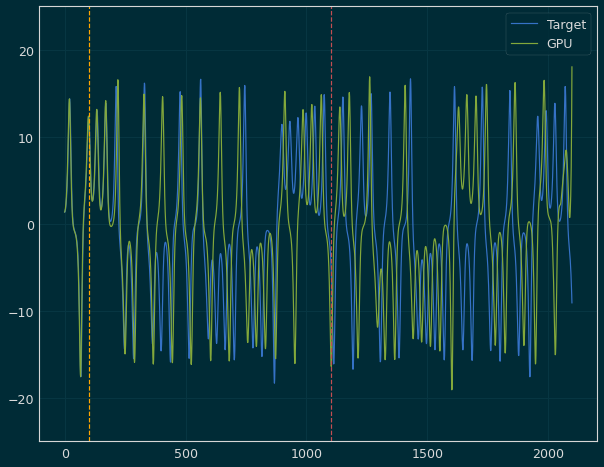

 Iter=89 a=0.327 sr=1.335 amp=0.816  ri=0.658 rr=1.688 loss=0.692616


Iter: 89 #### Diagnostic 0.692616   Time 6.06  Best 0.693 NRMSE 0.204 CD 0.489
Iter: 90 #### Diagnostic 1000.000000   Time 5.16  Best 0.693 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 4.57  Best 0.693 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 4.74  Best 0.693 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 5.96  Best 0.693 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 4.80  Best 0.693 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 5.28  Best 0.693 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 5.16  Best 0.693 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1.140111   Time 5.32  Best 0.693 NRMSE 0.286 CD 0.855
Iter: 98 #### Diagnostic 1000.000000   Time 6.52  Best 0.693 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 5.37  Best 0.693 NRMSE 1000.000 CD nan

Best result = 0.6926161

Iter: 82 #### Diagnostic 1000.000000   Time 5.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1.064712   Time 4.97  Best 1000.000 NRMSE 0.276 CD 0.789
Iter: 84 #### Diagnostic 1000.000000   Time 4.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 6.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 5.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 5.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 6.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.378333   Time 4.85  Best 1000.000 NRMSE 0.308 CD 1.070
Iter: 90 #### Diagnostic 1000.000000   Time 5.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 6.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 7.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 5.39  Best 1000.00

Iter: 69 #### Diagnostic 1000.000000   Time 5.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 5.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 7.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 5.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 5.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 5.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 5.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 5.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 5.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 5.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 4.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 4.87  Best

Iter: 63 #### Diagnostic 1000.000000   Time 5.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 5.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 4.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 5.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 5.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 4.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 5.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 4.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 5.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 5.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 6.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 5.20  Best

Iter: 57 #### Diagnostic 1.399292   Time 6.13  Best 1000.000 NRMSE 0.327 CD 1.073
Iter: 58 #### Diagnostic 1000.000000   Time 5.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 5.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 5.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1.213210   Time 4.70  Best 1000.000 NRMSE 0.299 CD 0.914
Iter: 63 #### Diagnostic 1000.000000   Time 5.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 5.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 5.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 5.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 5.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 5.69  Best 1000.00

Iter: 51 #### Diagnostic 1000.000000   Time 5.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 5.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 5.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 5.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 4.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 5.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 6.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 6.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 5.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 4.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 6.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 5.26  Best

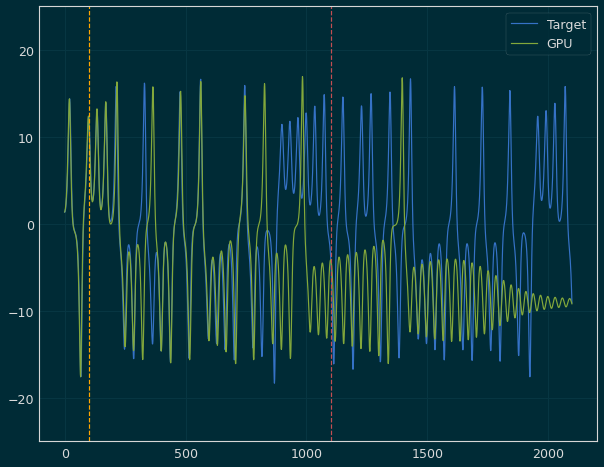

 Iter=91 a=0.322 sr=1.266 amp=0.936  ri=0.075 rr=3.015 loss=0.776054


Iter: 91 #### Diagnostic 0.776054   Time 5.66  Best 0.776 NRMSE 0.221 CD 0.555
Iter: 92 #### Diagnostic 1000.000000   Time 5.59  Best 0.776 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 5.12  Best 0.776 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 6.84  Best 0.776 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 6.49  Best 0.776 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1.383925   Time 6.97  Best 0.776 NRMSE 0.319 CD 1.065
Iter: 97 #### Diagnostic 1000.000000   Time 6.06  Best 0.776 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 6.03  Best 0.776 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 5.12  Best 0.776 NRMSE 1000.000 CD nan

Best result = 0.7760540458185177
a = 0.3221278440966887
sr = 1.2656673496732707
amp = 0.9363913091495087
ri = 0.0754619383819558
rr = 3.0150992876305307
********** Size 200 -- Run 4 *******

Iter: 84 #### Diagnostic 1000.000000   Time 4.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 5.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 5.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 5.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 5.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 5.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 4.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 4.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 5.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 5.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1.172384   Time 5.62  Best 10

Iter: 71 #### Diagnostic 1000.000000   Time 4.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 6.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 5.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1.292131   Time 4.89  Best 1000.000 NRMSE 0.296 CD 0.996
Iter: 75 #### Diagnostic 1000.000000   Time 5.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 7.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 6.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 7.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 4.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1.356598   Time 4.90  Best 1000.000 NRMSE 0.316 CD 1.040
Iter: 81 #### Diagnostic 1.385617   Time 5.32  Best 1000.000 NRMSE 0.326 CD 1.059
Iter: 82 #### Diagnostic 1000.000000   Time 5.32  Best 1000.000 NR

Iter: 65 #### Diagnostic 1000.000000   Time 5.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1.065407   Time 5.48  Best 1000.000 NRMSE 0.261 CD 0.804
Iter: 67 #### Diagnostic 1000.000000   Time 5.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 5.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 5.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 5.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.324157   Time 4.77  Best 1000.000 NRMSE 0.301 CD 1.023
Iter: 72 #### Diagnostic 1.344611   Time 5.42  Best 1000.000 NRMSE 0.305 CD 1.040
Iter: 73 #### Diagnostic 1000.000000   Time 5.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1.346689   Time 7.20  Best 1000.000 NRMSE 0.310 CD 1.037
Iter: 75 #### Diagnostic 1000.000000   Time 6.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 5.97  Best 1000.000 NRMSE 

Iter: 59 #### Diagnostic 1000.000000   Time 7.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 5.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 5.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 5.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 6.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 5.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 5.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 5.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 5.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 5.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 5.81  Best

Iter: 53 #### Diagnostic 1000.000000   Time 5.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 5.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 4.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 4.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 4.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 5.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 5.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 5.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1.363498   Time 5.95  Best 1000.000 NRMSE 0.301 CD 1.062
Iter: 62 #### Diagnostic 1000.000000   Time 4.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 5.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 5.98  Best 100

Iter: 47 #### Diagnostic 1000.000000   Time 6.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 5.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 6.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 5.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 5.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 5.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 6.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 5.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 5.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 7.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1.297239   Time 6.83  Best 1000.000 NRMSE 0.299 CD 0.998
Iter: 58 #### Diagnostic 1000.000000   Time 6.58  Best 100

Iter: 38 #### Diagnostic 1000.000000   Time 5.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 4.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 4.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 6.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 6.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 4.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 4.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 4.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1.561505   Time 4.71  Best 1000.000 NRMSE 0.657 CD 0.904
Iter: 47 #### Diagnostic 1000.000000   Time 5.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 4.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 4.26  Best 100

Iter: 32 #### Diagnostic 1000.000000   Time 5.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 4.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1.638872   Time 4.48  Best 1000.000 NRMSE 0.673 CD 0.966
Iter: 35 #### Diagnostic 1000.000000   Time 4.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 5.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 4.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 5.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 6.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 4.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 4.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 4.73  Best 100

Iter: 26 #### Diagnostic 1000.000000   Time 4.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 4.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 4.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 4.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 5.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 5.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 4.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 4.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 4.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 4.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1.390851   Time 4.67  Best 1000.000 NRMSE 0.313 CD 1.078
Iter: 37 #### Diagnostic 1000.000000   Time 5.10  Best 100

Iter: 20 #### Diagnostic 1000.000000   Time 4.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 4.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 5.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 5.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 5.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 4.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 4.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.357129   Time 4.87  Best 1000.000 NRMSE 0.317 CD 1.040
Iter: 29 #### Diagnostic 1000.000000   Time 4.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 5.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 6.77  Best 100

Iter: 14 #### Diagnostic 1000.000000   Time 4.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 5.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 4.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 5.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 4.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 5.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 4.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 4.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 4.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 4.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1.344240   Time 4.96  Best 1000.000 NRMSE 0.298 CD 1.046
Iter: 25 #### Diagnostic 1000.000000   Time 4.42  Best 100

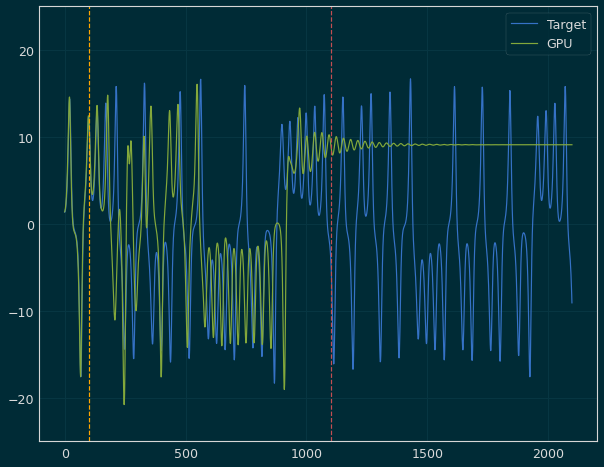

 Iter=75 a=0.338 sr=1.437 amp=1.086  ri=0.200 rr=2.432 loss=0.811758


Iter: 75 #### Diagnostic 0.811758   Time 4.55  Best 0.812 NRMSE 0.227 CD 0.585
Iter: 76 #### Diagnostic 1000.000000   Time 4.31  Best 0.812 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 4.72  Best 0.812 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 5.41  Best 0.812 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1.312400   Time 5.46  Best 0.812 NRMSE 0.303 CD 1.009
Iter: 80 #### Diagnostic 1000.000000   Time 5.53  Best 0.812 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 5.13  Best 0.812 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 4.54  Best 0.812 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 0.855815   Time 4.76  Best 0.812 NRMSE 0.233 CD 0.623
Iter: 84 #### Diagnostic 1000.000000   Time 4.40  Best 0.812 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1.217795   Time 4.34  Best 0.812 NRMSE 0.287 CD 0.931
Iter: 86 #### Diagnostic 1000.00

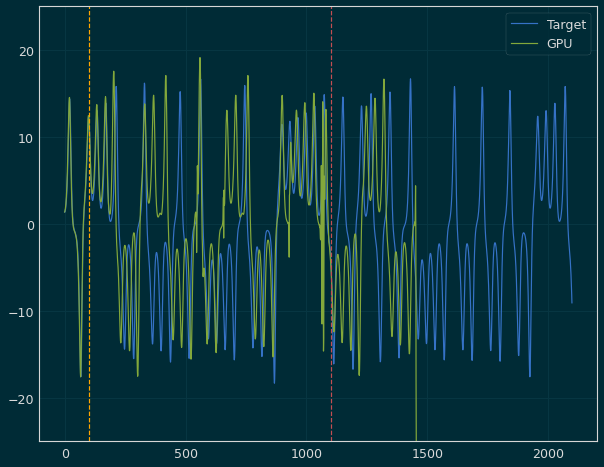

 Iter=57 a=0.376 sr=1.304 amp=0.989  ri=2.318 rr=2.193 loss=0.793040


Iter: 57 #### Diagnostic 0.793040   Time 4.69  Best 0.793 NRMSE 0.223 CD 0.570
Iter: 58 #### Diagnostic 1.353133   Time 4.17  Best 0.793 NRMSE 0.302 CD 1.051
Iter: 59 #### Diagnostic 1.299696   Time 4.40  Best 0.793 NRMSE 0.298 CD 1.002
Iter: 60 #### Diagnostic 1000.000000   Time 4.25  Best 0.793 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 4.33  Best 0.793 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 4.18  Best 0.793 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 4.32  Best 0.793 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 4.39  Best 0.793 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.363756   Time 4.39  Best 0.793 NRMSE 0.307 CD 1.057
Iter: 66 #### Diagnostic 1.314270   Time 4.47  Best 0.793 NRMSE 0.301 CD 1.014
Iter: 67 #### Diagnostic 1000.000000   Time 4.45  Best 0.793 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000

Iter: 53 #### Diagnostic 1000.000000   Time 4.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.358824   Time 4.09  Best 1000.000 NRMSE 0.303 CD 1.056
Iter: 55 #### Diagnostic 1000.000000   Time 5.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 5.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 4.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 4.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.389336   Time 4.11  Best 1000.000 NRMSE 0.324 CD 1.065
Iter: 60 #### Diagnostic 1000.000000   Time 4.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.392854   Time 4.05  Best 1000.000 NRMSE 0.327 CD 1.066
Iter: 64 #### Diagnostic 1.366530   Time 4.11  Best 1000.000 NRMSE

Iter: 48 #### Diagnostic 1000.000000   Time 4.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.255671   Time 4.11  Best 1000.000 NRMSE 0.293 CD 0.963
Iter: 51 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 4.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.354523   Time 4.07  Best 1000.000 NRMSE 0.307 CD 1.047
Iter: 55 #### Diagnostic 1000.000000   Time 4.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.370093   Time 4.08  Best 1000.000 NRMSE 0.318 CD 1.053
Iter: 57 #### Diagnostic 0.908426   Time 4.00  Best 1000.000 NRMSE 0.239 CD 0.670
Iter: 58 #### Diagnostic 1.368104   Time 4.39  Best 1000.000 NRMSE 0.304 CD 1.064
Iter: 59 #### Diagnostic 1000.000000   Time 4.11  Best 1000.000 NRMSE 1000

Iter: 43 #### Diagnostic 1.350546   Time 4.13  Best 1000.000 NRMSE 0.309 CD 1.042
Iter: 44 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1.338859   Time 4.25  Best 1000.000 NRMSE 0.291 CD 1.048
Iter: 47 #### Diagnostic 0.959321   Time 4.06  Best 1000.000 NRMSE 0.247 CD 0.712
Iter: 48 #### Diagnostic 1000.000000   Time 4.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 4.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.369600   Time 4.19  Best 1000.000 NRMSE 0.313 CD 1.057
Iter: 51 #### Diagnostic 1000.000000   Time 4.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 4.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.240040   Time 4.03  Best 1000.000 NRMSE 0.2

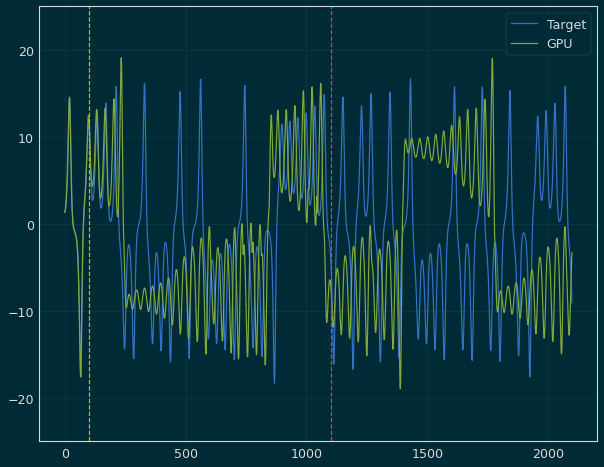

 Iter=61 a=0.257 sr=1.369 amp=1.048  ri=2.371 rr=3.967 loss=0.841412


Iter: 61 #### Diagnostic 0.841412   Time 5.24  Best 0.841 NRMSE 0.236 CD 0.606
Iter: 62 #### Diagnostic 1000.000000   Time 5.84  Best 0.841 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 5.50  Best 0.841 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.106088   Time 4.88  Best 0.841 NRMSE 0.270 CD 0.836
Iter: 65 #### Diagnostic 1.338298   Time 4.03  Best 0.841 NRMSE 0.302 CD 1.036
Iter: 66 #### Diagnostic 1.687437   Time 4.43  Best 0.841 NRMSE 0.351 CD 1.336
Iter: 67 #### Diagnostic 1000.000000   Time 4.21  Best 0.841 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1.157791   Time 4.03  Best 0.841 NRMSE 0.282 CD 0.876
Iter: 69 #### Diagnostic 1.399999   Time 4.26  Best 0.841 NRMSE 0.335 CD 1.065
Iter: 70 #### Diagnostic 1.398590   Time 4.51  Best 0.841 NRMSE 0.334 CD 1.064
Iter: 71 #### Diagnostic 1000.000000   Time 4.06  Best 0.841 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.369849   Time 4.0

Iter: 57 #### Diagnostic 1.360339   Time 4.19  Best 1000.000 NRMSE 0.305 CD 1.056
Iter: 58 #### Diagnostic 1.400315   Time 4.54  Best 1000.000 NRMSE 0.313 CD 1.087
Iter: 59 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 4.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 4.29  Best 1000.000 NRMSE 20522557011.625 CD 0.981
Iter: 62 #### Diagnostic 1000.000000   Time 4.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.409644   Time 4.07  Best 1000.000 NRMSE 0.320 CD 1.090
Iter: 65 #### Diagnostic 1000.000000   Time 4.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 4.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1.384424   Time 4.17  Best 1000.000 NRMSE 0.321 CD 1.064
Iter: 68 #### Diagnostic 1.323526   Time 4.22  Best 1000.000 

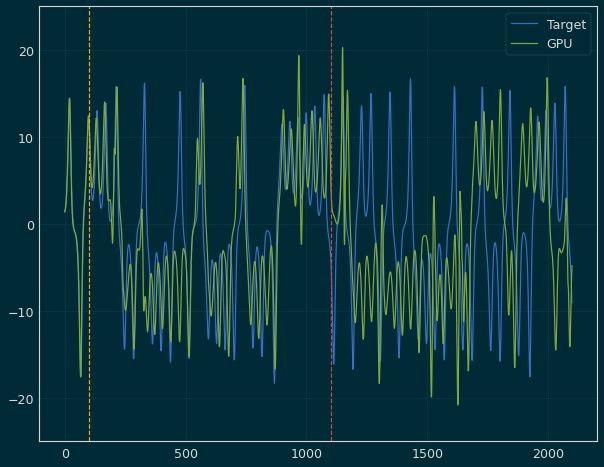

 Iter=25 a=0.334 sr=1.412 amp=1.022  ri=1.286 rr=3.648 loss=0.535446


Iter: 25 #### Diagnostic 0.535446   Time 4.49  Best 0.535 NRMSE 0.178 CD 0.357
Iter: 26 #### Diagnostic 1000.000000   Time 3.95  Best 0.535 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 3.90  Best 0.535 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 3.83  Best 0.535 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.358334   Time 3.87  Best 0.535 NRMSE 0.305 CD 1.054
Iter: 30 #### Diagnostic 0.975044   Time 3.94  Best 0.535 NRMSE 0.256 CD 0.719
Iter: 31 #### Diagnostic 1000.000000   Time 3.89  Best 0.535 NRMSE 44755817.136 CD 1.021
Iter: 32 #### Diagnostic 1.388261   Time 3.84  Best 0.535 NRMSE 0.324 CD 1.064
Iter: 33 #### Diagnostic 1.391891   Time 3.99  Best 0.535 NRMSE 0.309 CD 1.082
Iter: 34 #### Diagnostic 1.014280   Time 3.89  Best 0.535 NRMSE 0.262 CD 0.752
Iter: 35 #### Diagnostic 1000.000000   Time 3.92  Best 0.535 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.0000

Iter: 22 #### Diagnostic 1.376820   Time 5.51  Best 1000.000 NRMSE 0.311 CD 1.066
Iter: 23 #### Diagnostic 1000.000000   Time 4.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 4.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.326613   Time 4.62  Best 1000.000 NRMSE 0.299 CD 1.027
Iter: 26 #### Diagnostic 1000.000000   Time 5.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 4.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 4.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 4.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.401012   Time 4.06  Best 1000.000 NRMSE 0.335 CD 1.066
Iter: 33 #### Diagnostic 1.324011   Time 3.93  Best 1000.000 NRMSE

Iter: 17 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.360252   Time 3.95  Best 1000.000 NRMSE 0.313 CD 1.048
Iter: 19 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.354592   Time 3.89  Best 1000.000 NRMSE 0.302 CD 1.052
Iter: 21 #### Diagnostic 1.359824   Time 3.87  Best 1000.000 NRMSE 0.302 CD 1.058
Iter: 22 #### Diagnostic 1000.000000   Time 3.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1.368011   Time 4.06  Best 1000.000 NRMSE 0.312 CD 1.056
Iter: 25 #### Diagnostic 1000.000000   Time 4.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 4.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 4.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 4.14  Best 1000.000 NRMSE 

Iter: 12 #### Diagnostic 1.181285   Time 3.94  Best 1000.000 NRMSE 0.286 CD 0.896
Iter: 13 #### Diagnostic 1000.000000   Time 4.08  Best 1000.000 NRMSE 43791248074909488.000 CD 1.000
Iter: 14 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.362783   Time 4.53  Best 1000.000 NRMSE 0.307 CD 1.056
Iter: 16 #### Diagnostic 1.443637   Time 4.23  Best 1000.000 NRMSE 0.366 CD 1.078
Iter: 17 #### Diagnostic 1.135741   Time 4.49  Best 1000.000 NRMSE 0.287 CD 0.848
Iter: 18 #### Diagnostic 1000.000000   Time 4.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 4.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 4.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.350899   Time 4.07  Best 1000.000 NRMSE 0.306 CD 1.045
Iter: 23 #### Diagnostic 1000.000000   Time 4.14  Best 1000

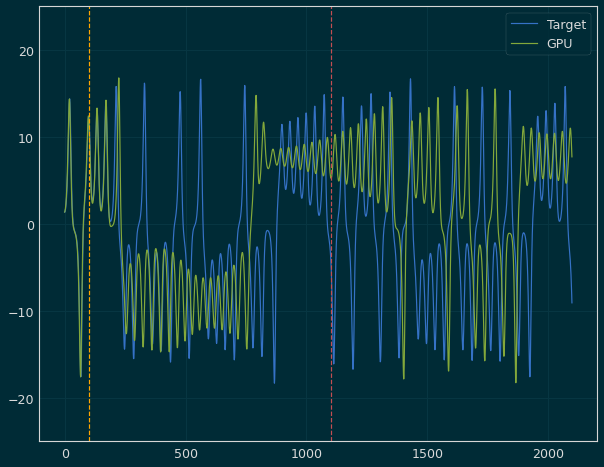

 Iter=68 a=0.387 sr=1.422 amp=1.080  ri=0.134 rr=3.665 loss=0.830981


Iter: 68 #### Diagnostic 0.830981   Time 5.22  Best 0.831 NRMSE 0.233 CD 0.598
Iter: 69 #### Diagnostic 1.330447   Time 4.04  Best 0.831 NRMSE 0.303 CD 1.027
Iter: 70 #### Diagnostic 1.136256   Time 4.02  Best 0.831 NRMSE 0.292 CD 0.845
Iter: 71 #### Diagnostic 1000.000000   Time 4.18  Best 0.831 NRMSE 291067145319927215554945875968.000 CD 1.000
Iter: 72 #### Diagnostic 1000.000000   Time 4.07  Best 0.831 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1.349803   Time 4.11  Best 0.831 NRMSE 0.303 CD 1.047
Iter: 74 #### Diagnostic 1000.000000   Time 4.21  Best 0.831 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 4.16  Best 0.831 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 4.33  Best 0.831 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 5.01  Best 0.831 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1.399672   Time 5.59  Best 0.831 NRMSE 0.308 CD 1.091
Iter: 79

Iter: 64 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.386955   Time 4.03  Best 1000.000 NRMSE 0.324 CD 1.063
Iter: 66 #### Diagnostic 1.341388   Time 4.05  Best 1000.000 NRMSE 0.303 CD 1.038
Iter: 67 #### Diagnostic 1000.000000   Time 4.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 4.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.010420   Time 4.28  Best 1000.000 NRMSE 0.257 CD 0.754
Iter: 70 #### Diagnostic 1000.000000   Time 4.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.400026   Time 5.04  Best 1000.000 NRMSE 0.334 CD 1.066
Iter: 73 #### Diagnostic 1.366741   Time 4.60  Best 1000.000 NRMSE 0.304 CD 1.063
Iter: 74 #### Diagnostic 1000.000000   Time 4.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1.380131   Time 3.92  Best 1000.000 NRMSE 0.321 C

Iter: 53 #### Diagnostic 1000.000000   Time 4.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 4.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1.343464   Time 4.37  Best 1000.000 NRMSE 0.295 CD 1.048
Iter: 56 #### Diagnostic 0.979109   Time 4.61  Best 1000.000 NRMSE 0.226 CD 0.753
Iter: 57 #### Diagnostic 1.326786   Time 4.18  Best 1000.000 NRMSE 0.299 CD 1.028
Iter: 58 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1.368886   Time 3.96  Best 1000.000 NRMSE 0.311 CD 1.058
Iter: 61 #### Diagnostic 1.379730   Time 4.83  Best 1000.000 NRMSE 0.316 CD 1.064
Iter: 62 #### Diagnostic 1000.000000   Time 4.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 4.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 4.13  Best 1000.000 NRMSE 1000

Iter: 48 #### Diagnostic 1000.000000   Time 4.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 4.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.327876   Time 4.10  Best 1000.000 NRMSE 0.299 CD 1.028
Iter: 51 #### Diagnostic 1000.000000   Time 4.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 4.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.321110   Time 4.06  Best 1000.000 NRMSE 0.300 CD 1.021
Iter: 54 #### Diagnostic 1.377783   Time 4.10  Best 1000.000 NRMSE 0.317 CD 1.061
Iter: 55 #### Diagnostic 1.343686   Time 4.24  Best 1000.000 NRMSE 0.293 CD 1.051
Iter: 56 #### Diagnostic 1.342766   Time 4.82  Best 1000.000 NRMSE 0.288 CD 1.055
Iter: 57 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 4.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.359899   Time 4.17  Best 1000.000 NRMSE 0.312 C

Iter: 43 #### Diagnostic 1000.000000   Time 4.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1.393575   Time 4.45  Best 1000.000 NRMSE 0.309 CD 1.084
Iter: 46 #### Diagnostic 1.384255   Time 4.20  Best 1000.000 NRMSE 0.322 CD 1.062
Iter: 47 #### Diagnostic 1000.000000   Time 4.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 4.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.356310   Time 3.97  Best 1000.000 NRMSE 0.312 CD 1.044
Iter: 50 #### Diagnostic 1.387556   Time 4.73  Best 1000.000 NRMSE 0.306 CD 1.081
Iter: 51 #### Diagnostic 1000.000000   Time 5.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 4.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 4.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 4.11  Best 1000.000 NRMSE 

Iter: 38 #### Diagnostic 1.359610   Time 4.08  Best 1000.000 NRMSE 0.302 CD 1.057
Iter: 39 #### Diagnostic 1000.000000   Time 4.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.342573   Time 4.19  Best 1000.000 NRMSE 0.306 CD 1.037
Iter: 41 #### Diagnostic 1.363213   Time 4.11  Best 1000.000 NRMSE 0.308 CD 1.055
Iter: 42 #### Diagnostic 1000.000000   Time 4.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.367904   Time 4.30  Best 1000.000 NRMSE 0.305 CD 1.063
Iter: 44 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1.283900   Time 4.02  Best 1000.000 NRMSE 0.361 CD 0.922
Iter: 47 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 4.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000

Iter: 33 #### Diagnostic 1000.000000   Time 4.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 4.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.400513   Time 4.02  Best 1000.000 NRMSE 0.336 CD 1.065
Iter: 38 #### Diagnostic 1000.000000   Time 4.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.116622   Time 4.02  Best 1000.000 NRMSE 0.264 CD 0.852
Iter: 40 #### Diagnostic 1.373071   Time 4.07  Best 1000.000 NRMSE 0.310 CD 1.063
Iter: 41 #### Diagnostic 1.357977   Time 4.09  Best 1000.000 NRMSE 0.310 CD 1.048
Iter: 42 #### Diagnostic 1.394231   Time 4.10  Best 1000.000 NRMSE 0.324 CD 1.070
Iter: 43 #### Diagnostic 1.389683   Time 4.13  Best 1000.000 NRMSE 0.305 CD 1.085
Iter: 44 #### Diagnostic 1.364035   Time 4.12  Best 1000.000 NRMSE 0.304 CD 1.

Iter: 24 #### Diagnostic 1.372147   Time 4.12  Best 1000.000 NRMSE 0.316 CD 1.056
Iter: 25 #### Diagnostic 1000.000000   Time 4.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1.383569   Time 4.18  Best 1000.000 NRMSE 0.321 CD 1.062
Iter: 27 #### Diagnostic 1000.000000   Time 4.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 4.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 4.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.370183   Time 4.05  Best 1000.000 NRMSE 0.310 CD 1.060
Iter: 32 #### Diagnostic 1000.000000   Time 4.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 4.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 4.21  Best 1000.000 NR

Iter: 19 #### Diagnostic 1000.000000   Time 4.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1.355666   Time 4.39  Best 1000.000 NRMSE 0.305 CD 1.051
Iter: 22 #### Diagnostic 1000.000000   Time 4.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 4.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1.348046   Time 4.36  Best 1000.000 NRMSE 0.301 CD 1.047
Iter: 25 #### Diagnostic 1.347713   Time 4.16  Best 1000.000 NRMSE 0.307 CD 1.041
Iter: 26 #### Diagnostic 1000.000000   Time 4.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.380725   Time 4.07  Best 1000.000 NRMSE 0.323 CD 1.058
Iter: 28 #### Diagnostic 1.345486   Time 4.09  Best 1000.000 NRMSE 0.291 CD 1.054
Iter: 29 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 4.20  Best 1000.000 NRMSE 1000

Iter: 14 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.367915   Time 4.15  Best 1000.000 NRMSE 0.322 CD 1.046
Iter: 16 #### Diagnostic 1000.000000   Time 4.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 4.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 4.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 4.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 4.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 4.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 4.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 4.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 4.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.252512   Time 4.15  Best 1000.0

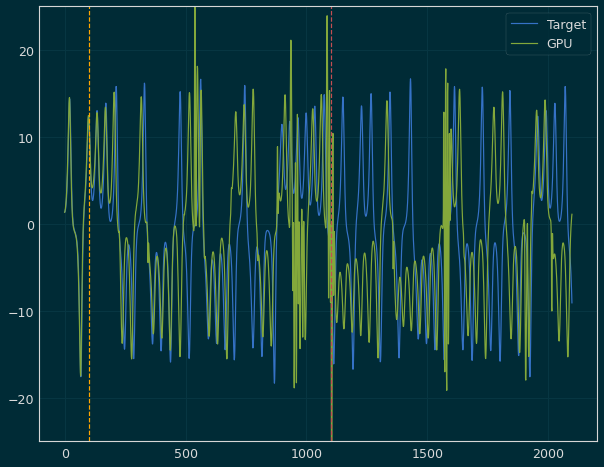

 Iter=39 a=0.370 sr=1.430 amp=0.908  ri=3.536 rr=1.225 loss=0.845335


Iter: 39 #### Diagnostic 0.845335   Time 4.46  Best 0.845 NRMSE 0.235 CD 0.610
Iter: 40 #### Diagnostic 1000.000000   Time 4.28  Best 0.845 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 4.10  Best 0.845 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 4.10  Best 0.845 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 4.10  Best 0.845 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1.241149   Time 4.07  Best 0.845 NRMSE 0.290 CD 0.951
Iter: 45 #### Diagnostic 1.421398   Time 4.13  Best 0.845 NRMSE 0.343 CD 1.079
Iter: 46 #### Diagnostic 1000.000000   Time 4.06  Best 0.845 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 4.05  Best 0.845 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.305995   Time 4.01  Best 0.845 NRMSE 0.299 CD 1.007
Iter: 49 #### Diagnostic 1000.000000   Time 4.09  Best 0.845 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.35812

Iter: 36 #### Diagnostic 1000.000000   Time 4.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.363018   Time 4.28  Best 1000.000 NRMSE 0.307 CD 1.057
Iter: 38 #### Diagnostic 1.407585   Time 4.32  Best 1000.000 NRMSE 0.333 CD 1.075
Iter: 39 #### Diagnostic 1000.000000   Time 4.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 4.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1.388606   Time 4.12  Best 1000.000 NRMSE 0.324 CD 1.065
Iter: 42 #### Diagnostic 1000.000000   Time 4.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 738873735585421514745315328.000 CD 1.000
Iter: 45 #### Diagnostic 1000.000000   Time 4.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 4.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Ti

Iter: 31 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.167029   Time 4.12  Best 1000.000 NRMSE 0.292 CD 0.875
Iter: 33 #### Diagnostic 1000.000000   Time 4.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 4.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1.386059   Time 4.07  Best 1000.000 NRMSE 0.311 CD 1.075
Iter: 37 #### Diagnostic 1000.000000   Time 4.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 4.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 4.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 4.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.394662   Time 4.05  Best 1000.000 N

Iter: 19 #### Diagnostic 1000.000000   Time 4.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.370718   Time 4.30  Best 1000.000 NRMSE 0.312 CD 1.059
Iter: 21 #### Diagnostic 1000.000000   Time 4.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.183437   Time 4.16  Best 1000.000 NRMSE 0.283 CD 0.900
Iter: 23 #### Diagnostic 1000.000000   Time 4.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 4.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 4.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 4.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.502952   Time 4.30  Best 1000.000 NRMSE 0.516 CD 0.987
Iter: 28 #### Diagnostic 1000.000000   Time 4.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.406200   Time 4.12  Best 1000.000 NRMSE 0.340 CD 1.066
Iter: 30 #### Diagnostic 1.375668   Time 4.07  Best 1000.000 NRMSE 0.3

Iter: 14 #### Diagnostic 1000.000000   Time 4.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1.370230   Time 4.03  Best 1000.000 NRMSE 0.316 CD 1.054
Iter: 17 #### Diagnostic 1000.000000   Time 4.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 4.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 4.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 4.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 4.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 4.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 4.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 4.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 4.08  Best 100

Iter: 9 #### Diagnostic 1000.000000   Time 4.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.367632   Time 4.09  Best 1000.000 NRMSE 0.318 CD 1.050
Iter: 11 #### Diagnostic 1000.000000   Time 4.11  Best 1000.000 NRMSE 3329455369203883825887707136.000 CD 1.000
Iter: 12 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.303741   Time 4.83  Best 1000.000 NRMSE 0.297 CD 1.007
Iter: 14 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 4.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.129226   Time 4.02  Best 1000.000 NRMSE 0.273 CD 0.856
Iter: 18 #### Diagnostic 1.277436   Time 4.14  Best 1000.000 NRMSE 0.289 CD 0.989
Iter: 19 #### Diagnostic 1.372169   Time 4.02  Best 1000.000 NRMSE 0.307 CD 1.065
Iter: 20 #### Diagnostic 1.015966   Time 4.13  Be

Iter: 4 #### Diagnostic 1000.000000   Time 4.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1.381464   Time 4.02  Best 1000.000 NRMSE 0.316 CD 1.065
Iter: 7 #### Diagnostic 1000.000000   Time 4.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 4.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 4.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.379325   Time 4.41  Best 1000.000 NRMSE 0.311 CD 1.069
Iter: 11 #### Diagnostic 1000.000000   Time 4.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1.069246   Time 4.11  Best 1000.000 NRMSE 0.275 CD 0.794
Iter: 13 #### Diagnostic 1000.000000   Time 5.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.395987   Time 4.17  Best 1000.000 NRMSE 0.331 CD 1.065
Iter: 15 #### Diagnostic 1000.000000   Time 4.45  Best 1000.000 NRMSE 1000.0

Iter: 0 #### Diagnostic 1000.000000   Time 4.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 4.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 4.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1.305513   Time 4.23  Best 1000.000 NRMSE 0.273 CD 1.032
Iter: 4 #### Diagnostic 1.332947   Time 4.09  Best 1000.000 NRMSE 0.304 CD 1.029
Iter: 5 #### Diagnostic 1000.000000   Time 4.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1.367778   Time 5.09  Best 1000.000 NRMSE 0.314 CD 1.054
Iter: 7 #### Diagnostic 1.378980   Time 4.21  Best 1000.000 NRMSE 0.320 CD 1.059
Iter: 8 #### Diagnostic 1000.000000   Time 4.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 4.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 4.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 4.11  Best 1000.000 NRMSE 1000.000 C

Iter: 97 #### Diagnostic 1.317967   Time 4.10  Best 1000.000 NRMSE 0.298 CD 1.020
Iter: 98 #### Diagnostic 1000.000000   Time 4.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 4.04  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 1.1169533208410587
a = 0.3899727693946672
sr = 1.4424640257744517
amp = 0.9045825779539804
ri = 3.447782004507261
rr = 2.542863837907216
Refined search bounds:

Alpha (0.12930764043393042, 0.7137730759883973)

Rho (0.5255905295010687, 2.6655711583808523)

Gamma (0.34683388928296, 1.8926935704938173)

r-in (0.9649235867986963, 5.167513542455241)

r-res (0.6028696072375818, 5.221254709123788)

End Refinement Run 4 Time 2101.652
********** Size 50 -- Run 0 ***********
Iter: 0 #### Diagnostic 1.110581   Time 4.11  Best 1000.000 NRMSE 0.265 CD 0.846
Iter: 1 #### Diagnostic 1.314907   Time 3.95  Best 1000.000 NRMSE 0.303 CD 1.012
Iter: 2 #### Diagnostic 1.089922   Time 4.02  Best 1000.000 NRMSE 0.267 CD 0.822
Iter: 3 #### Diagn

Iter: 90 #### Diagnostic 1.233261   Time 4.03  Best 1000.000 NRMSE 0.272 CD 0.961
Iter: 91 #### Diagnostic 1000.000000   Time 4.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 0.974205   Time 4.00  Best 1000.000 NRMSE 0.244 CD 0.730
Iter: 93 #### Diagnostic 0.995232   Time 4.01  Best 1000.000 NRMSE 0.252 CD 0.743
Iter: 94 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1.140571   Time 5.03  Best 1000.000 NRMSE 0.284 CD 0.857
Iter: 96 #### Diagnostic 1.060332   Time 4.19  Best 1000.000 NRMSE 0.258 CD 0.803
Iter: 97 #### Diagnostic 1.317736   Time 4.07  Best 1000.000 NRMSE 0.304 CD 1.014
Iter: 98 #### Diagnostic 1.278251   Time 4.02  Best 1000.000 NRMSE 0.285 CD 0.994
Iter: 99 #### Diagnostic 1.406600   Time 4.05  Best 1000.000 NRMSE 0.334 CD 1.072

Best result = 0.8809230335428346
a = 0.2910277429690908
sr = 1.2599486693677728
amp = 0.827799351545581
ri = 1.9548368152411848
rr = 2.4151872587096803
********** Size 50 

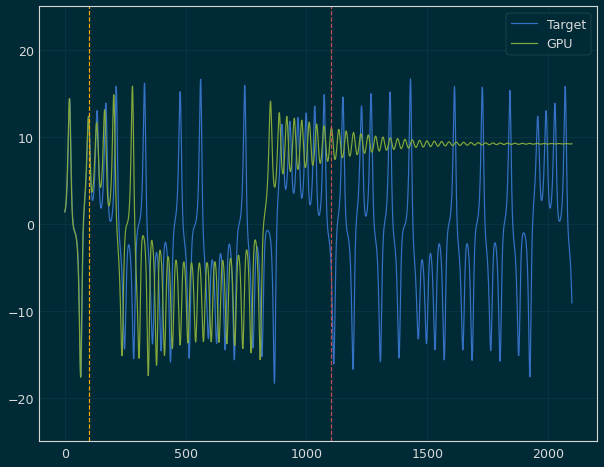

 Iter=31 a=0.371 sr=1.252 amp=0.978  ri=0.226 rr=0.892 loss=0.782247


Iter: 31 #### Diagnostic 0.782247   Time 4.38  Best 0.782 NRMSE 0.230 CD 0.552
Iter: 32 #### Diagnostic 1.344397   Time 4.05  Best 0.782 NRMSE 0.308 CD 1.036
Iter: 33 #### Diagnostic 1.459224   Time 4.06  Best 0.782 NRMSE 0.321 CD 1.138
Iter: 34 #### Diagnostic 1.337221   Time 4.02  Best 0.782 NRMSE 0.292 CD 1.045
Iter: 35 #### Diagnostic 1000.000000   Time 4.05  Best 0.782 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1.294262   Time 4.08  Best 0.782 NRMSE 0.293 CD 1.001
Iter: 37 #### Diagnostic 1000.000000   Time 4.07  Best 0.782 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1.365012   Time 4.13  Best 0.782 NRMSE 0.318 CD 1.047
Iter: 39 #### Diagnostic 1000.000000   Time 4.21  Best 0.782 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.133238   Time 4.04  Best 0.782 NRMSE 0.267 CD 0.866
Iter: 41 #### Diagnostic 1000.000000   Time 4.01  Best 0.782 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.379343   Time 4.0

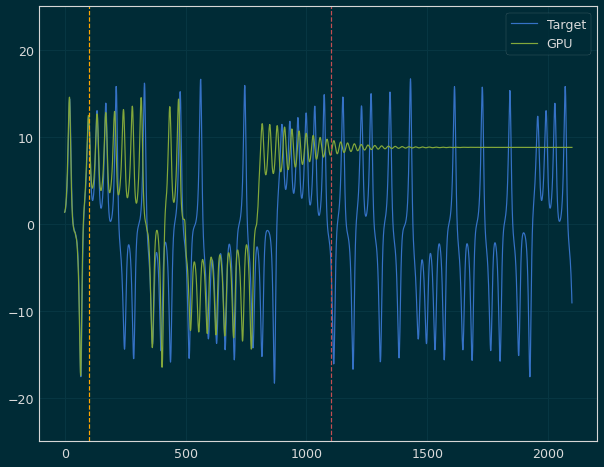

 Iter=5 a=0.373 sr=1.302 amp=1.068  ri=2.874 rr=0.083 loss=0.835778


Iter: 5 #### Diagnostic 0.835778   Time 5.16  Best 0.836 NRMSE 0.231 CD 0.605
Iter: 6 #### Diagnostic 0.959653   Time 4.41  Best 0.836 NRMSE 0.241 CD 0.718
Iter: 7 #### Diagnostic 1.385404   Time 4.98  Best 0.836 NRMSE 0.312 CD 1.073
Iter: 8 #### Diagnostic 1000.000000   Time 5.02  Best 0.836 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.394546   Time 4.04  Best 0.836 NRMSE 0.328 CD 1.066
Iter: 10 #### Diagnostic 1.050416   Time 3.86  Best 0.836 NRMSE 0.261 CD 0.789
Iter: 11 #### Diagnostic 1.411305   Time 3.94  Best 0.836 NRMSE 0.334 CD 1.078
Iter: 12 #### Diagnostic 1.179528   Time 3.98  Best 0.836 NRMSE 0.279 CD 0.900
Iter: 13 #### Diagnostic 1.384084   Time 4.27  Best 0.836 NRMSE 0.323 CD 1.061
Iter: 14 #### Diagnostic 1.300625   Time 4.71  Best 0.836 NRMSE 0.298 CD 1.002
Iter: 15 #### Diagnostic 1.215099   Time 4.09  Best 0.836 NRMSE 0.293 CD 0.922
Iter: 16 #### Diagnostic 1.388078   Time 4.17  Best 0.836 NRMS

Iter: 4 #### Diagnostic 1.379726   Time 3.90  Best 1000.000 NRMSE 0.303 CD 1.076
Iter: 5 #### Diagnostic 1.380131   Time 3.89  Best 1000.000 NRMSE 0.317 CD 1.063
Iter: 6 #### Diagnostic 1.478331   Time 3.84  Best 1000.000 NRMSE 0.324 CD 1.155
Iter: 7 #### Diagnostic 1.404611   Time 3.88  Best 1000.000 NRMSE 0.336 CD 1.068
Iter: 8 #### Diagnostic 1.390371   Time 3.85  Best 1000.000 NRMSE 0.328 CD 1.062
Iter: 9 #### Diagnostic 1.386232   Time 3.91  Best 1000.000 NRMSE 0.309 CD 1.077
Iter: 10 #### Diagnostic 1000.000000   Time 3.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.386068   Time 3.89  Best 1000.000 NRMSE 0.327 CD 1.060
Iter: 12 #### Diagnostic 1.002288   Time 3.83  Best 1000.000 NRMSE 0.261 CD 0.741
Iter: 13 #### Diagnostic 1.432432   Time 3.88  Best 1000.000 NRMSE 0.310 CD 1.123
Iter: 14 #### Diagnostic 1.180267   Time 3.87  Best 1000.000 NRMSE 0.279 CD 0.901
Iter: 15 #### Diagnostic 1000.000000   Time 3.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### 

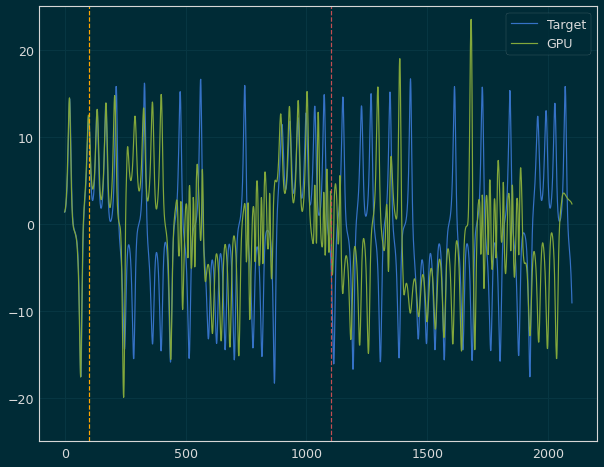

 Iter=33 a=0.358 sr=1.276 amp=1.096  ri=1.187 rr=0.932 loss=0.848012


Iter: 33 #### Diagnostic 0.848012   Time 4.29  Best 0.848 NRMSE 0.220 CD 0.628
Iter: 34 #### Diagnostic 1.378350   Time 3.87  Best 0.848 NRMSE 0.315 CD 1.064
Iter: 35 #### Diagnostic 1.402420   Time 3.87  Best 0.848 NRMSE 0.328 CD 1.074
Iter: 36 #### Diagnostic 1000.000000   Time 3.89  Best 0.848 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.312318   Time 3.89  Best 0.848 NRMSE 0.295 CD 1.017
Iter: 38 #### Diagnostic 1.348626   Time 4.73  Best 0.848 NRMSE 0.366 CD 0.983
Iter: 39 #### Diagnostic 1000.000000   Time 4.76  Best 0.848 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.237166   Time 3.85  Best 0.848 NRMSE 0.300 CD 0.937
Iter: 41 #### Diagnostic 0.993102   Time 3.90  Best 0.848 NRMSE 0.251 CD 0.742
Iter: 42 #### Diagnostic 1.349172   Time 3.92  Best 0.848 NRMSE 0.295 CD 1.054
Iter: 43 #### Diagnostic 1.384722   Time 3.87  Best 0.848 NRMSE 0.322 CD 1.062
Iter: 44 #### Diagnostic 1.391037   Time 3.90  Best 

Iter: 31 #### Diagnostic 1.323006   Time 3.89  Best 1000.000 NRMSE 0.297 CD 1.026
Iter: 32 #### Diagnostic 1.414148   Time 3.80  Best 1000.000 NRMSE 0.321 CD 1.094
Iter: 33 #### Diagnostic 1.178474   Time 3.84  Best 1000.000 NRMSE 0.291 CD 0.888


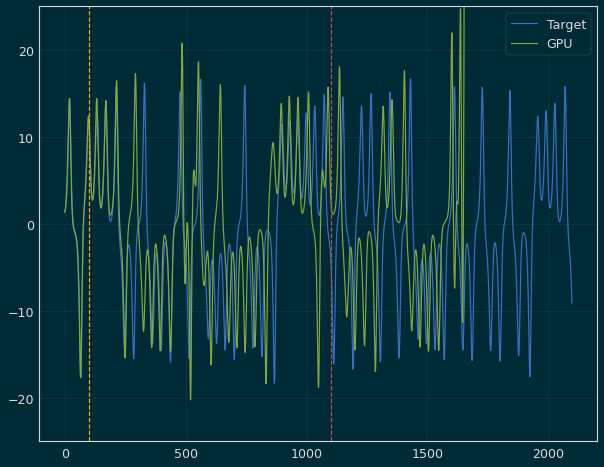

 Iter=34 a=0.316 sr=1.439 amp=0.806  ri=0.421 rr=1.777 loss=0.793735


Iter: 34 #### Diagnostic 0.793735   Time 4.23  Best 0.794 NRMSE 0.225 CD 0.568
Iter: 35 #### Diagnostic 1.370352   Time 3.86  Best 0.794 NRMSE 0.296 CD 1.075
Iter: 36 #### Diagnostic 1000.000000   Time 3.86  Best 0.794 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 3.98  Best 0.794 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 3.89  Best 0.794 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.388649   Time 3.94  Best 0.794 NRMSE 0.317 CD 1.071
Iter: 40 #### Diagnostic 1.376264   Time 4.09  Best 0.794 NRMSE 0.317 CD 1.060
Iter: 41 #### Diagnostic 1.384545   Time 4.04  Best 0.794 NRMSE 0.326 CD 1.059
Iter: 42 #### Diagnostic 1.401000   Time 4.02  Best 0.794 NRMSE 0.338 CD 1.063
Iter: 43 #### Diagnostic 1.379190   Time 4.04  Best 0.794 NRMSE 0.329 CD 1.050
Iter: 44 #### Diagnostic 1000.000000   Time 3.89  Best 0.794 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1.387167   Time 3.8

Iter: 25 #### Diagnostic 1.381301   Time 3.86  Best 1000.000 NRMSE 0.315 CD 1.066
Iter: 26 #### Diagnostic 1.404287   Time 3.87  Best 1000.000 NRMSE 0.339 CD 1.066
Iter: 27 #### Diagnostic 1.115132   Time 3.92  Best 1000.000 NRMSE 0.272 CD 0.843
Iter: 28 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.436458   Time 3.92  Best 1000.000 NRMSE 0.320 CD 1.117
Iter: 30 #### Diagnostic 1.387909   Time 3.95  Best 1000.000 NRMSE 0.326 CD 1.061
Iter: 31 #### Diagnostic 1.393152   Time 3.93  Best 1000.000 NRMSE 0.326 CD 1.067
Iter: 32 #### Diagnostic 1.403073   Time 3.97  Best 1000.000 NRMSE 0.326 CD 1.077
Iter: 33 #### Diagnostic 1.338993   Time 3.85  Best 1000.000 NRMSE 0.300 CD 1.039
Iter: 34 #### Diagnostic 1.363170   Time 3.95  Best 1000.000 NRMSE 0.312 CD 1.051
Iter: 35 #### Diagnostic 1.398518   Time 3.95  Best 1000.000 NRMSE 0.310 CD 1.089
Iter: 36 #### Diagnostic 1.140805   Time 3.93  Best 1000.000 NRMSE 0.282 CD 0.859
Iter: 37 ###

Iter: 22 #### Diagnostic 1.377033   Time 3.86  Best 1000.000 NRMSE 0.312 CD 1.065
Iter: 23 #### Diagnostic 1.396331   Time 4.27  Best 1000.000 NRMSE 0.305 CD 1.092
Iter: 24 #### Diagnostic 1000.000000   Time 4.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.037129   Time 3.95  Best 1000.000 NRMSE 0.208 CD 0.829
Iter: 26 #### Diagnostic 1.390870   Time 3.92  Best 1000.000 NRMSE 0.324 CD 1.067
Iter: 27 #### Diagnostic 1.400622   Time 3.88  Best 1000.000 NRMSE 0.336 CD 1.064
Iter: 28 #### Diagnostic 1.059728   Time 3.85  Best 1000.000 NRMSE 0.277 CD 0.783
Iter: 29 #### Diagnostic 1000.000000   Time 3.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1.433521   Time 3.83  Best 1000.000 NRMSE 0.293 CD 1.141
Iter: 31 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.131268   Time 3.86  Best 1000.000 NRMSE 0.272 CD 0.859
Iter: 33 #### Diagnostic 1000.000000   Time 3.85  Best 1000.000 NRMSE 1000.000 CD nan


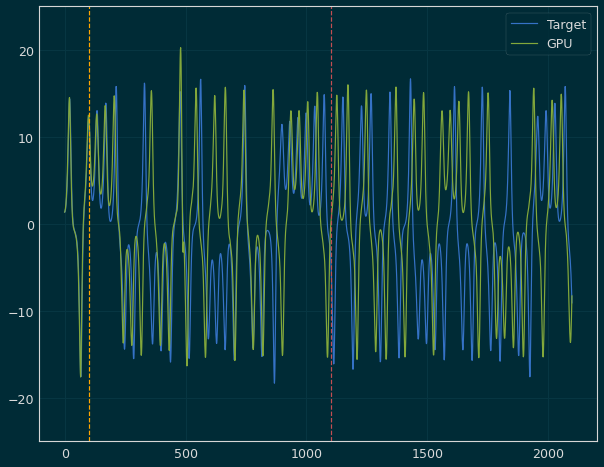

 Iter=71 a=0.276 sr=1.308 amp=1.001  ri=1.989 rr=0.259 loss=0.844453


Iter: 71 #### Diagnostic 0.844453   Time 4.24  Best 0.844 NRMSE 0.231 CD 0.613
Iter: 72 #### Diagnostic 1000.000000   Time 4.01  Best 0.844 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 3.99  Best 0.844 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1.369712   Time 4.13  Best 0.844 NRMSE 0.285 CD 1.085
Iter: 75 #### Diagnostic 1.397859   Time 4.19  Best 0.844 NRMSE 0.329 CD 1.069
Iter: 76 #### Diagnostic 1.225041   Time 4.10  Best 0.844 NRMSE 0.279 CD 0.946
Iter: 77 #### Diagnostic 1.398142   Time 4.34  Best 0.844 NRMSE 0.332 CD 1.067
Iter: 78 #### Diagnostic 1.397017   Time 4.32  Best 0.844 NRMSE 0.308 CD 1.089
Iter: 79 #### Diagnostic 1.030251   Time 4.35  Best 0.844 NRMSE 0.277 CD 0.753
Iter: 80 #### Diagnostic 1000.000000   Time 4.18  Best 0.844 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 4.19  Best 0.844 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1.375985   Time 4.6

Iter: 67 #### Diagnostic 1.216141   Time 4.19  Best 1000.000 NRMSE 0.303 CD 0.913
Iter: 68 #### Diagnostic 1.393477   Time 4.11  Best 1000.000 NRMSE 0.301 CD 1.092
Iter: 69 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 4.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.360273   Time 4.19  Best 1000.000 NRMSE 0.303 CD 1.057
Iter: 72 #### Diagnostic 1.188930   Time 4.07  Best 1000.000 NRMSE 0.271 CD 0.918
Iter: 73 #### Diagnostic 1.394715   Time 4.40  Best 1000.000 NRMSE 0.313 CD 1.082
Iter: 74 #### Diagnostic 1.389700   Time 4.48  Best 1000.000 NRMSE 0.328 CD 1.062
Iter: 75 #### Diagnostic 1.426982   Time 4.87  Best 1000.000 NRMSE 0.313 CD 1.114
Iter: 76 #### Diagnostic 1000.000000   Time 4.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.391865   Time 4.16  Best 1000.000 NRMSE 0.328 CD 1.063
Iter: 78 #### Diagnostic 0.995100   Time 5.54  Best 1000.000 NRMSE 0.253 CD 0.743
Iter

Iter: 63 #### Diagnostic 1000.000000   Time 4.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.401980   Time 4.82  Best 1000.000 NRMSE 0.336 CD 1.066
Iter: 65 #### Diagnostic 1.398228   Time 4.20  Best 1000.000 NRMSE 0.333 CD 1.065
Iter: 66 #### Diagnostic 1000.000000   Time 4.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 4.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.222403   Time 4.23  Best 1000.000 NRMSE 0.279 CD 0.943
Iter: 70 #### Diagnostic 1000.000000   Time 4.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.092482   Time 4.27  Best 1000.000 NRMSE 0.268 CD 0.824
Iter: 72 #### Diagnostic 1.413170   Time 4.51  Best 1000.000 NRMSE 0.305 CD 1.108
Iter: 73 #### Diagnostic 1.274780   Time 4.26  Best 1000.000 NRMSE 0.291 CD 0.984
Iter: 74 #### Diagnostic 1.022558   Time 4.36  Best 1000.000 NRMSE 0.257 CD 0.

Iter: 60 #### Diagnostic 1.160794   Time 4.15  Best 1000.000 NRMSE 0.278 CD 0.883
Iter: 61 #### Diagnostic 1000.000000   Time 4.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1.388553   Time 3.99  Best 1000.000 NRMSE 0.317 CD 1.072
Iter: 63 #### Diagnostic 1.399147   Time 4.69  Best 1000.000 NRMSE 0.333 CD 1.066
Iter: 64 #### Diagnostic 1000.000000   Time 4.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 4.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 5.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1.321250   Time 4.05  Best 1000.000 NRMSE 0.299 CD 1.022
Iter: 68 #### Diagnostic 1000.000000   Time 4.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.372823   Time 4.59  Best 1000.000 NRMSE 0.301 CD 1.072
Iter: 70 #### Diagnostic 1.393895   Time 4.39  Best 1000.000 NRMSE 0.330 CD 1.064
Iter: 71 #### Diagnostic 1000.000000   Time 4.01  Best 1000.000 NRMSE 1000.000

Iter: 50 #### Diagnostic 1.349517   Time 4.12  Best 1000.000 NRMSE 0.281 CD 1.069
Iter: 51 #### Diagnostic 1.372697   Time 4.07  Best 1000.000 NRMSE 0.315 CD 1.058
Iter: 52 #### Diagnostic 1.296089   Time 4.06  Best 1000.000 NRMSE 0.287 CD 1.009
Iter: 53 #### Diagnostic 1.142670   Time 4.01  Best 1000.000 NRMSE 0.273 CD 0.870
Iter: 54 #### Diagnostic 1000.000000   Time 5.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 4.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.395005   Time 4.06  Best 1000.000 NRMSE 0.320 CD 1.075
Iter: 57 #### Diagnostic 1.325949   Time 4.19  Best 1000.000 NRMSE 0.295 CD 1.031
Iter: 58 #### Diagnostic 1.271036   Time 4.30  Best 1000.000 NRMSE 0.304 CD 0.967
Iter: 59 #### Diagnostic 1000.000000   Time 4.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1.382035   Time 4.74  Best 1000.000 NRMSE 0.320 CD 1.062
Iter: 61 #### Diagnostic 1.328905   Time 4.21  Best 1000.000 NRMSE 0.299 CD 1.030
Iter

Iter: 47 #### Diagnostic 1.370084   Time 4.02  Best 1000.000 NRMSE 0.312 CD 1.058
Iter: 48 #### Diagnostic 1.322395   Time 4.69  Best 1000.000 NRMSE 0.306 CD 1.016
Iter: 49 #### Diagnostic 1.352510   Time 4.20  Best 1000.000 NRMSE 0.303 CD 1.050
Iter: 50 #### Diagnostic 1000.000000   Time 4.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 4.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.348197   Time 4.09  Best 1000.000 NRMSE 0.311 CD 1.038
Iter: 54 #### Diagnostic 1.186049   Time 4.61  Best 1000.000 NRMSE 0.235 CD 0.951
Iter: 55 #### Diagnostic 1000.000000   Time 4.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 4.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 4.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.258283   Time 4.10  Best 1000.000 NRMSE 0.287 C

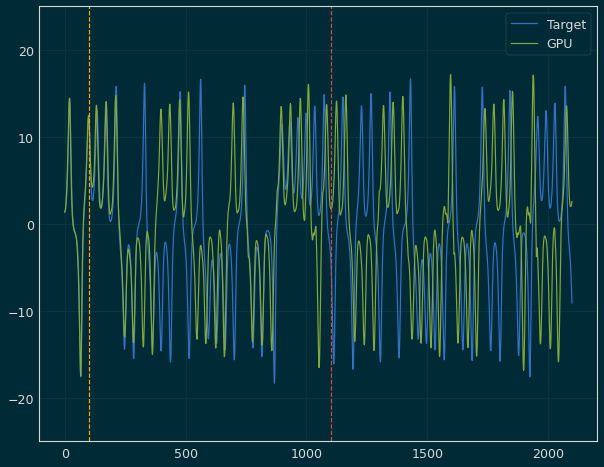

 Iter=14 a=0.322 sr=1.255 amp=0.952  ri=3.672 rr=0.829 loss=0.802664


Iter: 14 #### Diagnostic 0.802664   Time 4.49  Best 0.803 NRMSE 0.222 CD 0.580
Iter: 15 #### Diagnostic 1.400759   Time 4.50  Best 0.803 NRMSE 0.338 CD 1.063
Iter: 16 #### Diagnostic 1000.000000   Time 4.16  Best 0.803 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.135395   Time 4.65  Best 0.803 NRMSE 0.300 CD 0.835
Iter: 18 #### Diagnostic 1.151116   Time 4.49  Best 0.803 NRMSE 0.264 CD 0.887
Iter: 19 #### Diagnostic 1000.000000   Time 4.09  Best 0.803 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.387587   Time 4.26  Best 0.803 NRMSE 0.303 CD 1.085
Iter: 21 #### Diagnostic 1.351369   Time 5.09  Best 0.803 NRMSE 0.310 CD 1.041
Iter: 22 #### Diagnostic 1.397662   Time 6.00  Best 0.803 NRMSE 0.334 CD 1.064
Iter: 23 #### Diagnostic 1.172178   Time 5.47  Best 0.803 NRMSE 0.278 CD 0.894
Iter: 24 #### Diagnostic 0.915558   Time 5.77  Best 0.803 NRMSE 0.238 CD 0.678
Iter: 25 #### Diagnostic 1.371960   Time 6.37  Best 

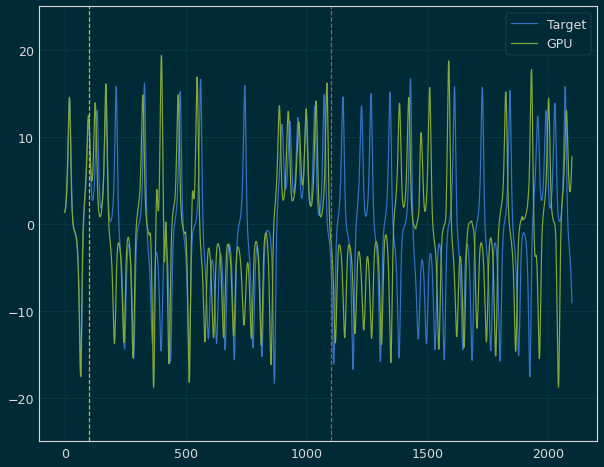

 Iter=11 a=0.315 sr=1.405 amp=0.989  ri=1.893 rr=2.183 loss=0.625049


Iter: 11 #### Diagnostic 0.625049   Time 4.59  Best 0.625 NRMSE 0.194 CD 0.431
Iter: 12 #### Diagnostic 1.525870   Time 3.96  Best 0.625 NRMSE 0.339 CD 1.187
Iter: 13 #### Diagnostic 1.134057   Time 4.40  Best 0.625 NRMSE 0.272 CD 0.862
Iter: 14 #### Diagnostic 1000.000000   Time 4.35  Best 0.625 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.229429   Time 4.08  Best 0.625 NRMSE 0.287 CD 0.942
Iter: 16 #### Diagnostic 1.357061   Time 4.42  Best 0.625 NRMSE 0.302 CD 1.055
Iter: 17 #### Diagnostic 1.368049   Time 5.08  Best 0.625 NRMSE 0.317 CD 1.051
Iter: 18 #### Diagnostic 1.242554   Time 4.55  Best 0.625 NRMSE 0.290 CD 0.953
Iter: 19 #### Diagnostic 1.231315   Time 4.38  Best 0.625 NRMSE 0.292 CD 0.940
Iter: 20 #### Diagnostic 1000.000000   Time 5.13  Best 0.625 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 4.31  Best 0.625 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.306584   Time 4.43  B

Iter: 11 #### Diagnostic 1.258999   Time 4.40  Best 1000.000 NRMSE 0.285 CD 0.974
Iter: 12 #### Diagnostic 1000.000000   Time 5.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.411775   Time 4.35  Best 1000.000 NRMSE 0.328 CD 1.084
Iter: 14 #### Diagnostic 1000.000000   Time 4.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 4.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1.397117   Time 4.25  Best 1000.000 NRMSE 0.331 CD 1.066
Iter: 17 #### Diagnostic 1.361933   Time 4.63  Best 1000.000 NRMSE 0.307 CD 1.055
Iter: 18 #### Diagnostic 1.195679   Time 4.18  Best 1000.000 NRMSE 0.291 CD 0.904
Iter: 19 #### Diagnostic 1.400337   Time 4.16  Best 1000.000 NRMSE 0.308 CD 1.092
Iter: 20 #### Diagnostic 1.360442   Time 4.82  Best 1000.000 NRMSE 0.289 CD 1.071
Iter: 21 #### Diagnostic 1000.000000   Time 5.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.223777   Time 4.06  Best 1000.000 NRMSE 0.284 CD 0.940


Iter: 1 #### Diagnostic 1.382418   Time 4.95  Best 1000.000 NRMSE 0.325 CD 1.058
Iter: 2 #### Diagnostic 1.249724   Time 4.88  Best 1000.000 NRMSE 0.277 CD 0.973
Iter: 3 #### Diagnostic 1.195580   Time 5.76  Best 1000.000 NRMSE 0.274 CD 0.922
Iter: 4 #### Diagnostic 1.156934   Time 5.30  Best 1000.000 NRMSE 0.269 CD 0.888
Iter: 5 #### Diagnostic 1.082854   Time 5.37  Best 1000.000 NRMSE 0.212 CD 0.871
Iter: 6 #### Diagnostic 1.374774   Time 4.35  Best 1000.000 NRMSE 0.315 CD 1.060
Iter: 7 #### Diagnostic 1.166661   Time 4.90  Best 1000.000 NRMSE 0.273 CD 0.894
Iter: 8 #### Diagnostic 1.390800   Time 4.81  Best 1000.000 NRMSE 0.324 CD 1.066
Iter: 9 #### Diagnostic 1000.000000   Time 4.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.385308   Time 4.61  Best 1000.000 NRMSE 0.323 CD 1.062
Iter: 11 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1.388787   Time 4.06  Best 1000.000 NRMSE 0.321 CD 1.068
Iter: 13 #### Dia

Iter: 0 #### Diagnostic 1.358347   Time 4.10  Best 1000.000 NRMSE 0.301 CD 1.057
Iter: 1 #### Diagnostic 1000.000000   Time 4.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.398628   Time 4.28  Best 1000.000 NRMSE 0.334 CD 1.065
Iter: 3 #### Diagnostic 1.371059   Time 4.39  Best 1000.000 NRMSE 0.320 CD 1.051
Iter: 4 #### Diagnostic 1.372468   Time 4.20  Best 1000.000 NRMSE 0.315 CD 1.057
Iter: 5 #### Diagnostic 1.383148   Time 5.49  Best 1000.000 NRMSE 0.327 CD 1.056
Iter: 6 #### Diagnostic 1.057601   Time 6.04  Best 1000.000 NRMSE 0.263 CD 0.794
Iter: 7 #### Diagnostic 1.025693   Time 5.49  Best 1000.000 NRMSE 0.263 CD 0.762
Iter: 8 #### Diagnostic 1000.000000   Time 4.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 6.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 5.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.382673   Time 4.98  Best 1000.000 NRMSE 0.307 CD 1.076
Iter: 12 #

Iter: 99 #### Diagnostic 1.388155   Time 4.11  Best 1000.000 NRMSE 0.326 CD 1.062

Best result = 0.9805716001776674
a = 0.387499743643666
sr = 1.3192805271997152
amp = 0.8575219250917623
ri = 0.8469294801823214
rr = 0.5917548836755158
********** Size 50 -- Run 2 ***********
Iter: 0 #### Diagnostic 1.413617   Time 4.12  Best 1000.000 NRMSE 0.349 CD 1.065
Iter: 1 #### Diagnostic 1000.000000   Time 4.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 4.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 0.943908   Time 4.06  Best 1000.000 NRMSE 0.249 CD 0.695
Iter: 4 #### Diagnostic 1.382561   Time 4.10  Best 1000.000 NRMSE 0.320 CD 1.062
Iter: 5 #### Diagnostic 1.402625   Time 3.99  Best 1000.000 NRMSE 0.329 CD 1.073
Iter: 6 #### Diagnostic 1000.000000   Time 4.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.048322   Time 4.09  Best 1000.000 NRMSE 0.271 CD 0.777
Iter: 8 #### Diagnostic 1.357365   Time 4.29  Best 1000.000 NRMSE

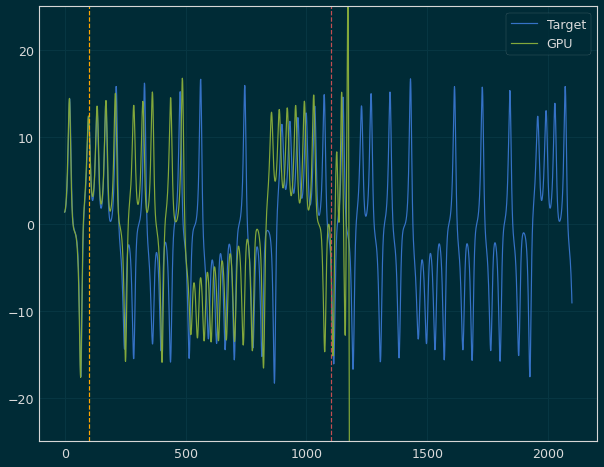

 Iter=40 a=0.293 sr=1.293 amp=0.926  ri=0.504 rr=3.972 loss=0.838905


Iter: 40 #### Diagnostic 0.838905   Time 5.30  Best 0.839 NRMSE 0.232 CD 0.607
Iter: 41 #### Diagnostic 1.520285   Time 5.84  Best 0.839 NRMSE 0.317 CD 1.203
Iter: 42 #### Diagnostic 1.393835   Time 5.73  Best 0.839 NRMSE 0.330 CD 1.064
Iter: 43 #### Diagnostic 1000.000000   Time 3.93  Best 0.839 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1.370135   Time 4.09  Best 0.839 NRMSE 0.297 CD 1.073
Iter: 45 #### Diagnostic 1000.000000   Time 4.41  Best 0.839 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1.168319   Time 4.13  Best 0.839 NRMSE 0.267 CD 0.901
Iter: 47 #### Diagnostic 1000.000000   Time 4.36  Best 0.839 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.326478   Time 4.22  Best 0.839 NRMSE 0.304 CD 1.023
Iter: 49 #### Diagnostic 1.349101   Time 4.02  Best 0.839 NRMSE 0.303 CD 1.046
Iter: 50 #### Diagnostic 1.404451   Time 4.14  Best 0.839 NRMSE 0.340 CD 1.065
Iter: 51 #### Diagnostic 1.350681   Time 4.10  B

Iter: 38 #### Diagnostic 1.005030   Time 5.53  Best 1000.000 NRMSE 0.263 CD 0.742
Iter: 39 #### Diagnostic 1.154389   Time 3.95  Best 1000.000 NRMSE 0.273 CD 0.881
Iter: 40 #### Diagnostic 1.402627   Time 4.10  Best 1000.000 NRMSE 0.331 CD 1.071
Iter: 41 #### Diagnostic 1.389263   Time 4.24  Best 1000.000 NRMSE 0.331 CD 1.058
Iter: 42 #### Diagnostic 1.359874   Time 3.96  Best 1000.000 NRMSE 0.301 CD 1.059
Iter: 43 #### Diagnostic 1.367070   Time 4.06  Best 1000.000 NRMSE 0.307 CD 1.060
Iter: 44 #### Diagnostic 1.387370   Time 4.49  Best 1000.000 NRMSE 0.321 CD 1.066
Iter: 45 #### Diagnostic 1000.000000   Time 4.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1.345506   Time 4.17  Best 1000.000 NRMSE 0.309 CD 1.037
Iter: 47 #### Diagnostic 1000.000000   Time 4.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.195929   Time 4.82  Best 1000.000 NRMSE 0.282 CD 0.914
Iter: 49 #### Diagnostic 1000.000000   Time 4.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter

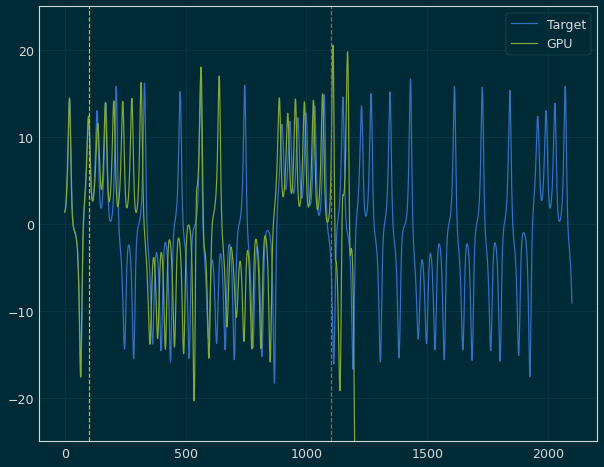

 Iter=58 a=0.354 sr=1.376 amp=1.053  ri=0.428 rr=3.615 loss=0.810745


Iter: 58 #### Diagnostic 0.810745   Time 5.20  Best 0.811 NRMSE 0.228 CD 0.583
Iter: 59 #### Diagnostic 1000.000000   Time 4.06  Best 0.811 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 4.17  Best 0.811 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1.119171   Time 4.78  Best 0.811 NRMSE 0.274 CD 0.845
Iter: 62 #### Diagnostic 1000.000000   Time 4.34  Best 0.811 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 4.04  Best 0.811 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.370730   Time 4.31  Best 0.811 NRMSE 0.303 CD 1.068
Iter: 65 #### Diagnostic 1.316214   Time 4.13  Best 0.811 NRMSE 0.299 CD 1.017
Iter: 66 #### Diagnostic 1.407068   Time 4.49  Best 0.811 NRMSE 0.326 CD 1.081
Iter: 67 #### Diagnostic 1.366285   Time 4.01  Best 0.811 NRMSE 0.304 CD 1.063
Iter: 68 #### Diagnostic 1.594270   Time 4.05  Best 0.811 NRMSE 0.514 CD 1.080
Iter: 69 #### Diagnostic 1.348123   Time 4.2

Iter: 55 #### Diagnostic 1.326651   Time 4.16  Best 1000.000 NRMSE 0.299 CD 1.028
Iter: 56 #### Diagnostic 1.072778   Time 4.12  Best 1000.000 NRMSE 0.260 CD 0.812
Iter: 57 #### Diagnostic 1.393715   Time 4.81  Best 1000.000 NRMSE 0.332 CD 1.062
Iter: 58 #### Diagnostic 1.401715   Time 4.25  Best 1000.000 NRMSE 0.337 CD 1.064
Iter: 59 #### Diagnostic 1.352173   Time 4.53  Best 1000.000 NRMSE 0.299 CD 1.053
Iter: 60 #### Diagnostic 1.410554   Time 4.76  Best 1000.000 NRMSE 0.308 CD 1.102
Iter: 61 #### Diagnostic 1.302481   Time 4.16  Best 1000.000 NRMSE 0.289 CD 1.014
Iter: 62 #### Diagnostic 1.106959   Time 5.29  Best 1000.000 NRMSE 0.279 CD 0.828
Iter: 63 #### Diagnostic 1000.000000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 4.56  Best 1000.000 NRMSE 790059308006841472.000 CD 1.000
Iter: 65 #### Diagnostic 1.286018   Time 4.42  Best 1000.000 NRMSE 0.273 CD 1.013
Iter: 66 #### Diagnostic 1.390662   Time 5.27  Best 1000.000 NRMSE 0.331 C

Iter: 45 #### Diagnostic 1.378686   Time 5.08  Best 1000.000 NRMSE 0.310 CD 1.069
Iter: 46 #### Diagnostic 1.401116   Time 4.15  Best 1000.000 NRMSE 0.337 CD 1.065
Iter: 47 #### Diagnostic 1.090791   Time 4.05  Best 1000.000 NRMSE 0.261 CD 0.830
Iter: 48 #### Diagnostic 1.144221   Time 5.31  Best 1000.000 NRMSE 0.277 CD 0.867
Iter: 49 #### Diagnostic 1.229368   Time 5.56  Best 1000.000 NRMSE 0.291 CD 0.938
Iter: 50 #### Diagnostic 1.284880   Time 4.05  Best 1000.000 NRMSE 0.298 CD 0.987
Iter: 51 #### Diagnostic 1.299972   Time 5.63  Best 1000.000 NRMSE 0.297 CD 1.003
Iter: 52 #### Diagnostic 1.366899   Time 4.89  Best 1000.000 NRMSE 0.317 CD 1.050
Iter: 53 #### Diagnostic 1.351047   Time 4.25  Best 1000.000 NRMSE 0.310 CD 1.041
Iter: 54 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1.399467   Time 4.60  Best 1000.000 NRMSE 0.322 CD 1.078
Iter: 56 #### Diagnostic 1.343870   Time 4.27  Best 1000.000 NRMSE 0.306 CD 1.038
Iter: 57 ###

Iter: 42 #### Diagnostic 1.395971   Time 4.02  Best 1000.000 NRMSE 0.328 CD 1.068
Iter: 43 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 3.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1.404433   Time 4.03  Best 1000.000 NRMSE 0.333 CD 1.071
Iter: 46 #### Diagnostic 1.403731   Time 3.99  Best 1000.000 NRMSE 0.308 CD 1.095
Iter: 47 #### Diagnostic 1.360920   Time 3.86  Best 1000.000 NRMSE 0.306 CD 1.054
Iter: 48 #### Diagnostic 1000.000000   Time 4.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 4.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.405772   Time 4.01  Best 1000.000 NRMSE 0.340 CD 1.065
Iter: 52 #### Diagnostic 1.321695   Time 3.96  Best 1000.000 NRMSE 0.289 CD 1.033
Iter: 53 #### Diagnostic 1.116502   Time 4.15  Best 1000.000 NRMSE 0.273 CD 0.

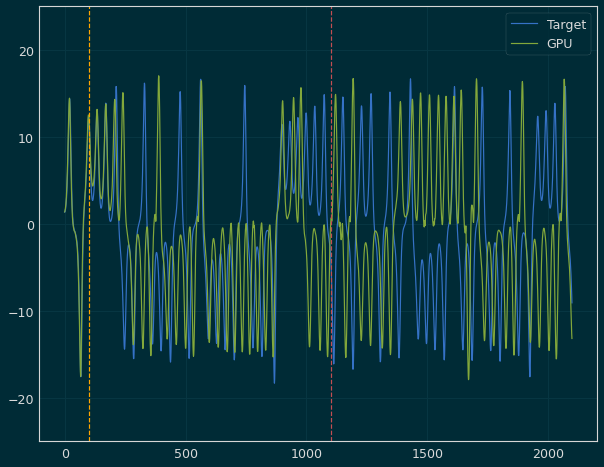

 Iter=76 a=0.324 sr=1.349 amp=0.861  ri=3.809 rr=3.002 loss=0.849478


Iter: 76 #### Diagnostic 0.849478   Time 4.74  Best 0.849 NRMSE 0.232 CD 0.617
Iter: 77 #### Diagnostic 1.218228   Time 5.05  Best 0.849 NRMSE 0.272 CD 0.946
Iter: 78 #### Diagnostic 1.384713   Time 3.89  Best 0.849 NRMSE 0.333 CD 1.052
Iter: 79 #### Diagnostic 1.152114   Time 3.90  Best 0.849 NRMSE 0.274 CD 0.878
Iter: 80 #### Diagnostic 1000.000000   Time 3.96  Best 0.849 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.388272   Time 3.90  Best 0.849 NRMSE 0.320 CD 1.069
Iter: 82 #### Diagnostic 1.390272   Time 4.05  Best 0.849 NRMSE 0.326 CD 1.065
Iter: 83 #### Diagnostic 1000.000000   Time 3.96  Best 0.849 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.377794   Time 5.02  Best 0.849 NRMSE 0.314 CD 1.063
Iter: 85 #### Diagnostic 1.404234   Time 4.48  Best 0.849 NRMSE 0.302 CD 1.102
Iter: 86 #### Diagnostic 1.368729   Time 4.80  Best 0.849 NRMSE 0.303 CD 1.065
Iter: 87 #### Diagnostic 1000.000000   Time 5.63  Be

Iter: 73 #### Diagnostic 1.122320   Time 4.07  Best 1000.000 NRMSE 0.280 CD 0.842
Iter: 74 #### Diagnostic 1.091418   Time 3.90  Best 1000.000 NRMSE 0.267 CD 0.824
Iter: 75 #### Diagnostic 1.413950   Time 4.27  Best 1000.000 NRMSE 0.313 CD 1.101
Iter: 76 #### Diagnostic 1000.000000   Time 4.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.170353   Time 3.95  Best 1000.000 NRMSE 0.280 CD 0.890
Iter: 78 #### Diagnostic 1000.000000   Time 4.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 4.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 4.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.397257   Time 5.29  Best 1000.000 NRMSE 0.331 CD 1.066
Iter: 82 #### Diagnostic 1.000322   Time 5.78  Best 1000.000 NRMSE 0.251 CD 0.749
Iter: 83 #### Diagnostic 1.396615   Time 4.98  Best 1000.000 NRMSE 0.331 CD 1.066
Iter: 84 #### Diagnostic 1.402007   Time 4.95  Best 1000.000 NRMSE 0.339 CD 1.063


Iter: 70 #### Diagnostic 1000.000000   Time 4.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 4.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.485208   Time 4.03  Best 1000.000 NRMSE 0.315 CD 1.170
Iter: 73 #### Diagnostic 1.104667   Time 4.10  Best 1000.000 NRMSE 0.292 CD 0.812
Iter: 74 #### Diagnostic 1.393404   Time 4.12  Best 1000.000 NRMSE 0.309 CD 1.084
Iter: 75 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 36240719877954251882490396812509184.000 CD 1.000
Iter: 76 #### Diagnostic 1.166711   Time 4.06  Best 1000.000 NRMSE 0.281 CD 0.886
Iter: 77 #### Diagnostic 1.153972   Time 3.99  Best 1000.000 NRMSE 0.302 CD 0.852
Iter: 78 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1.386787   Time 4.01  Best 1000.000 NRMSE 0.323 CD 1.064
Iter: 80 #### Diagnostic 1000.000000   Time 5.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.299551   Time 4.89

Iter: 66 #### Diagnostic 1.245440   Time 4.85  Best 1000.000 NRMSE 0.297 CD 0.948
Iter: 67 #### Diagnostic 1.225468   Time 3.99  Best 1000.000 NRMSE 0.287 CD 0.938
Iter: 68 #### Diagnostic 1.366490   Time 4.54  Best 1000.000 NRMSE 0.297 CD 1.069
Iter: 69 #### Diagnostic 1.618890   Time 4.11  Best 1000.000 NRMSE 0.333 CD 1.286
Iter: 70 #### Diagnostic 1.267815   Time 4.03  Best 1000.000 NRMSE 0.282 CD 0.985
Iter: 71 #### Diagnostic 1.272206   Time 4.16  Best 1000.000 NRMSE 0.317 CD 0.955
Iter: 72 #### Diagnostic 1.147287   Time 4.06  Best 1000.000 NRMSE 0.272 CD 0.875
Iter: 73 #### Diagnostic 1.158897   Time 3.89  Best 1000.000 NRMSE 0.241 CD 0.917
Iter: 74 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 0.920072   Time 4.05  Best 1000.000 NRMSE 0.240 CD 0.680
Iter: 76 #### Diagnostic 1.395876   Time 3.95  Best 1000.000 NRMSE 0.327 CD 1.069
Iter: 77 #### Diagnostic 1000.000000   Time 4.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78

In [5]:
CALLS = 100
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)
# Skipped 1000, 900
size = [300,200,100,50]
rand_state = [11,37,3,24,91]

for N in size:
    min_a, max_a = .25, .4
    min_sr, max_sr = 1.25, 1.45
    min_g, max_g = .8, 1.1
    min_ri, max_ri = .001, 4.
    min_rr, max_rr = .001, 4.
    space = [Real(min_a, max_a, name='a'),
                     Real(min_sr, max_sr, name='sr'),
                     Real(min_g, max_g, name='amp'), 
                     Real(min_ri, max_ri, name='ri'),
                     Real(min_rr, max_rr, name='rr')
                    ]
    for ref in range(5):
        start = time.time()
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []
        
        for rn in range(5):
            running_error = 1000
            counter = 0 
            print(f'********** Size {N} -- Run {rn} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=-1,
                                    n_initial_points=100)
            print(f'\nBest result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')
                
        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        end = time.time()-start
        print(f'End Refinement Run {ref} Time {end:.3f}')